In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import gc
from tqdm import tqdm
from captum.attr import KernelShap
import cv2

import shap
import numpy as np
from PIL import Image
import time

from model import Generator
from models import *
from combine_model import AlexNetMNIST, CombinedModel
from shapmap import shap_mapping
from utils import make_image, generate_heatmap, generate_color_heatmap

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
img_path = "test_sample/image/test.png"
latent_path = "test_sample/latent_code/test.pth"
sample = torch.load(latent_path)
sample.requires_grad = True

In [4]:
gan_path = "GAN_checkpoint/256_200000.pt"
g_ema = Generator(32, 256, 8)
g_ema.load_state_dict(torch.load(gan_path)["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.to(device)

In [5]:
model = VGG('VGG19')
model.to(device)
model_path = 'cifar_checkpoint/ckpt_vgg.pth'

from collections import OrderedDict
checkpoint = torch.load(model_path, map_location=device)

state_dict = checkpoint['net']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] if k.startswith("module.") else k 
    new_state_dict[name] = v

model.load_state_dict(new_state_dict, strict=False)

<All keys matched successfully>

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

image = Image.open(img_path)
image_np = np.array(image)
image_tensor = transform(image).unsqueeze(0).to(device)

In [7]:
model.eval()
output = model(image_tensor)
target = int(output.argmax().detach().cpu().numpy())
print('Prob', output)

Prob tensor([[ 0.1271, -0.4311, -1.4141, -1.5559, -1.3191, -1.1549, -1.1080, -1.4577,
         -1.0992,  9.4812]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [8]:
combined_model = CombinedModel(g_ema, model, transform)
combined_model = combined_model.to(device)

In [9]:
ks = KernelShap(combined_model)
n_samples = 1000
attributions = ks.attribute(sample, target=target, n_samples=n_samples, show_progress=True)

Kernel Shap attribution:   0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
map = shap_mapping(g_ema, image, sample, input_is_latent=True)
map = map.to(device)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:39<00:00,  3.11s/it]


In [11]:
attributions = attributions.view(256, 1, 1, 1)
attributions[attributions < 0] = 0

fusion_shap = attributions * map

In [12]:
fusion_max = fusion_shap.max()
fusion_min = fusion_shap.min()
fusion_norm = (fusion_shap - fusion_min) / (fusion_max - fusion_min)
Shapley = fusion_norm.mean(dim=0)
img_ar = make_image(Shapley.unsqueeze(0))

In [13]:
backgroud_set = torchvision.datasets.ImageFolder(root="background", transform=transform)
background_loader = torch.utils.data.DataLoader(backgroud_set, batch_size=330,shuffle=True)
classes = backgroud_set.classes

background_dataiter = iter(background_loader)
b_images, b_labels = next(background_dataiter)

b_images = b_images.to((device))
b_labels = b_labels.to((device))

In [14]:
image = Image.open(img_path)
image = transform(image)
image = image.unsqueeze(0)
image = image.to(device)

model.eval()

e = shap.GradientExplainer(model, b_images)
shap_values = e.shap_values(image)
shap_numpy_g = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]

In [15]:
target_label = target
gradient_shap = shap_numpy_g[target_label][0]
gradient_shap = np.sum(gradient_shap, axis=2)
gradient_shap = np.maximum(gradient_shap, 0)
gradient_shap = cv2.resize(gradient_shap, (32, 32))

latent_shap = img_ar[0, :, :, :]
latent_shap = np.mean(latent_shap, 2)
latent_shap = np.maximum(latent_shap, 0)
latent_shap = cv2.resize(latent_shap, (32, 32))

(-0.5, 31.5, 31.5, -0.5)

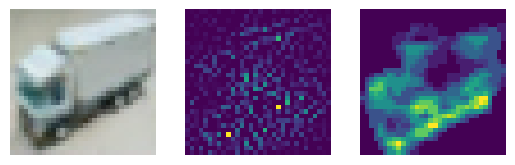

In [16]:
plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(gradient_shap)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(latent_shap)
plt.axis('off')